In [13]:
import os
import glob
import joblib
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, det_curve
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import python_speech_features as psf
from tqdm import tqdm

In [14]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
# List the languages you have models for (must match folder names)
LANGUAGES = [
  "English",
  "French",
  "Darija",
  "Nederlands",
  "Japanese"
]

# Where are your model folders located?
# Based on your image, they seem to be in the current directory or a specific root
MODELS_ROOT = "./"

# Where are your TEST audio files? (Update these paths!)
TEST_AUDIO_PATHS = {
    "English":    "./data/english_test/",
    "French":     "./data/french_test/",
    "Darija":     "./data/darija_test/",
    "Nederlands": "./data/nederlands_test/",
    "Japanese":   "./data/japanese_test/"
}

# Study Parameters
GMM_COMPONENTS = [4, 8, 16, 32, 64, 128, 256, 512]
SEGMENT_DURATIONS = [5, 10, 15]  # Seconds
MFCC_STEP = 0.01 # 10ms

#
NUM_CEP = 13  # Number of MFCC coefficients
WIN_FUNC = np.hanning  # Window function for MFCC

print("Configuration loaded.")

Configuration loaded.


In [15]:
# ==========================================
# 2. HELPER: LOAD MODELS
# ==========================================
def load_all_models():
    """Loads all .gmm files into a dictionary: models[lang][n_comp]"""
    models = {lang: {} for lang in LANGUAGES}
    print("--- Loading Models ---")

    for lang in LANGUAGES:
        for n in GMM_COMPONENTS:
            # Construct path based on your screenshot structure:
            # Folder: GMM_English / File: GMM_English_4.gmm
            path = os.path.join(MODELS_ROOT, f"GMM_{lang}", f"GMM_{lang}_{n}.gmm")

            # Also try .joblib extension just in case
            if not os.path.exists(path):
                path = os.path.join(MODELS_ROOT, f"GMM_{lang}", f"GMM_{lang}_{n}.joblib")

            if os.path.exists(path):
                try:
                    models[lang][n] = joblib.load(path)
                except Exception as e:
                    print(f"❌ Error loading {path}: {e}")
            else:
                print(f"⚠️ Warning: Model missing: {path}")
    return models

In [16]:
# ==========================================
# 3. HELPER: PROCESS AUDIO (HYBRID SILENCE REMOVAL)
# ==========================================
def process_audio_file(file_path):
    """Extracts MFCCs and removes silence using GMM+KMeans"""
    try:
        signal, sr = librosa.load(file_path, sr=None)
        if len(signal.shape) > 1: signal = signal[0]

        # Extract MFCCs
        n_fft = 1024 if sr <= 16000 else 2048
        mfccs = psf.mfcc(signal, sr, numcep=NUM_CEP, nfft=n_fft, winfunc=WIN_FUNC, appendEnergy=False)

        if len(mfccs) < 10: return None

        # Hybrid Silence Removal
        energies = np.sum(np.square(mfccs), axis=1).reshape(-1, 1)

        kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0).fit(energies)
        centers = kmeans.cluster_centers_.ravel()

        gmm = GaussianMixture(n_components=2, random_state=42, init_params="k-means++").fit(energies)
        means = gmm.means_.ravel()

        threshold = (np.min(means) + np.min(centers)) / 2
        is_speech = (energies > threshold).flatten()

        clean_mfcc = mfccs[is_speech]

        if len(clean_mfcc) < 10: return None

        # Add Deltas
        deltas = psf.delta(clean_mfcc, 2)
        features = np.hstack((clean_mfcc, deltas))

        return features

    except:
        return None

In [17]:
# ==========================================
# 4. PREPARE TEST DATA
# ==========================================
test_features = {lang: [] for lang in LANGUAGES}

print("\n--- Processing Test Audio Files ---")
for lang, folder in TEST_AUDIO_PATHS.items():
    if not os.path.exists(folder):
        print(f"⚠️ Warning: Test folder not found for {lang}: {folder}")
        continue

    files = glob.glob(os.path.join(folder, "*.flac")) + glob.glob(os.path.join(folder, "*.wav"))
    print(f"Processing {lang} ({len(files)} files)...")

    for f in tqdm(files):
        feat = process_audio_file(f)
        if feat is not None:
            test_features[lang].append(feat)


--- Processing Test Audio Files ---
Processing English (55 files)...


100%|██████████| 55/55 [00:02<00:00, 22.48it/s]


Processing French (55 files)...


100%|██████████| 55/55 [00:02<00:00, 26.69it/s]


Processing Darija (55 files)...


100%|██████████| 55/55 [00:01<00:00, 27.54it/s]


Processing Nederlands (55 files)...


100%|██████████| 55/55 [00:02<00:00, 20.07it/s]


Processing Japanese (55 files)...


100%|██████████| 55/55 [00:02<00:00, 23.56it/s]


--- Loading Models ---

--- Running Evaluation (Identification & Verification) ---

📂 Testing Segment Duration: 5s (500 frames)


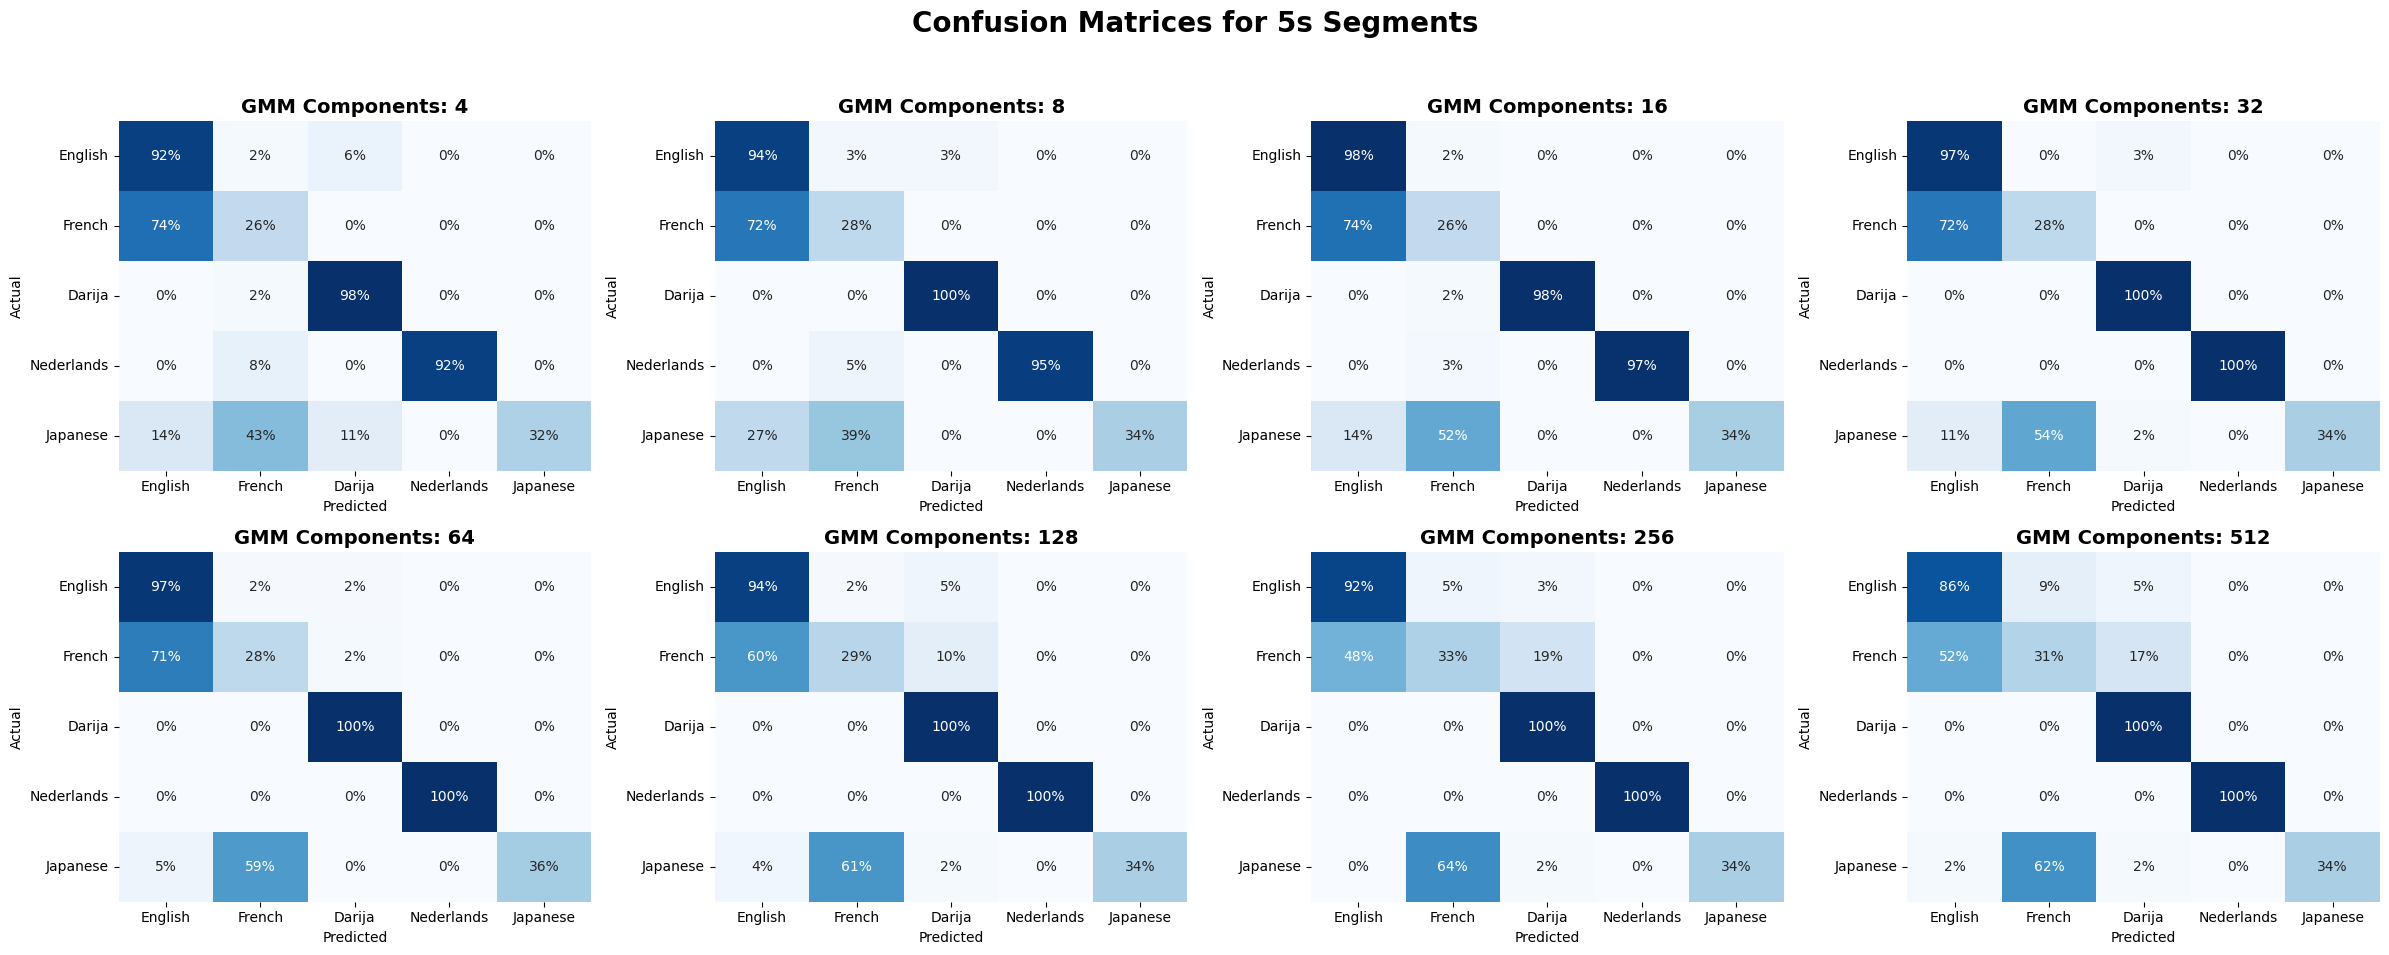


📂 Testing Segment Duration: 10s (1000 frames)


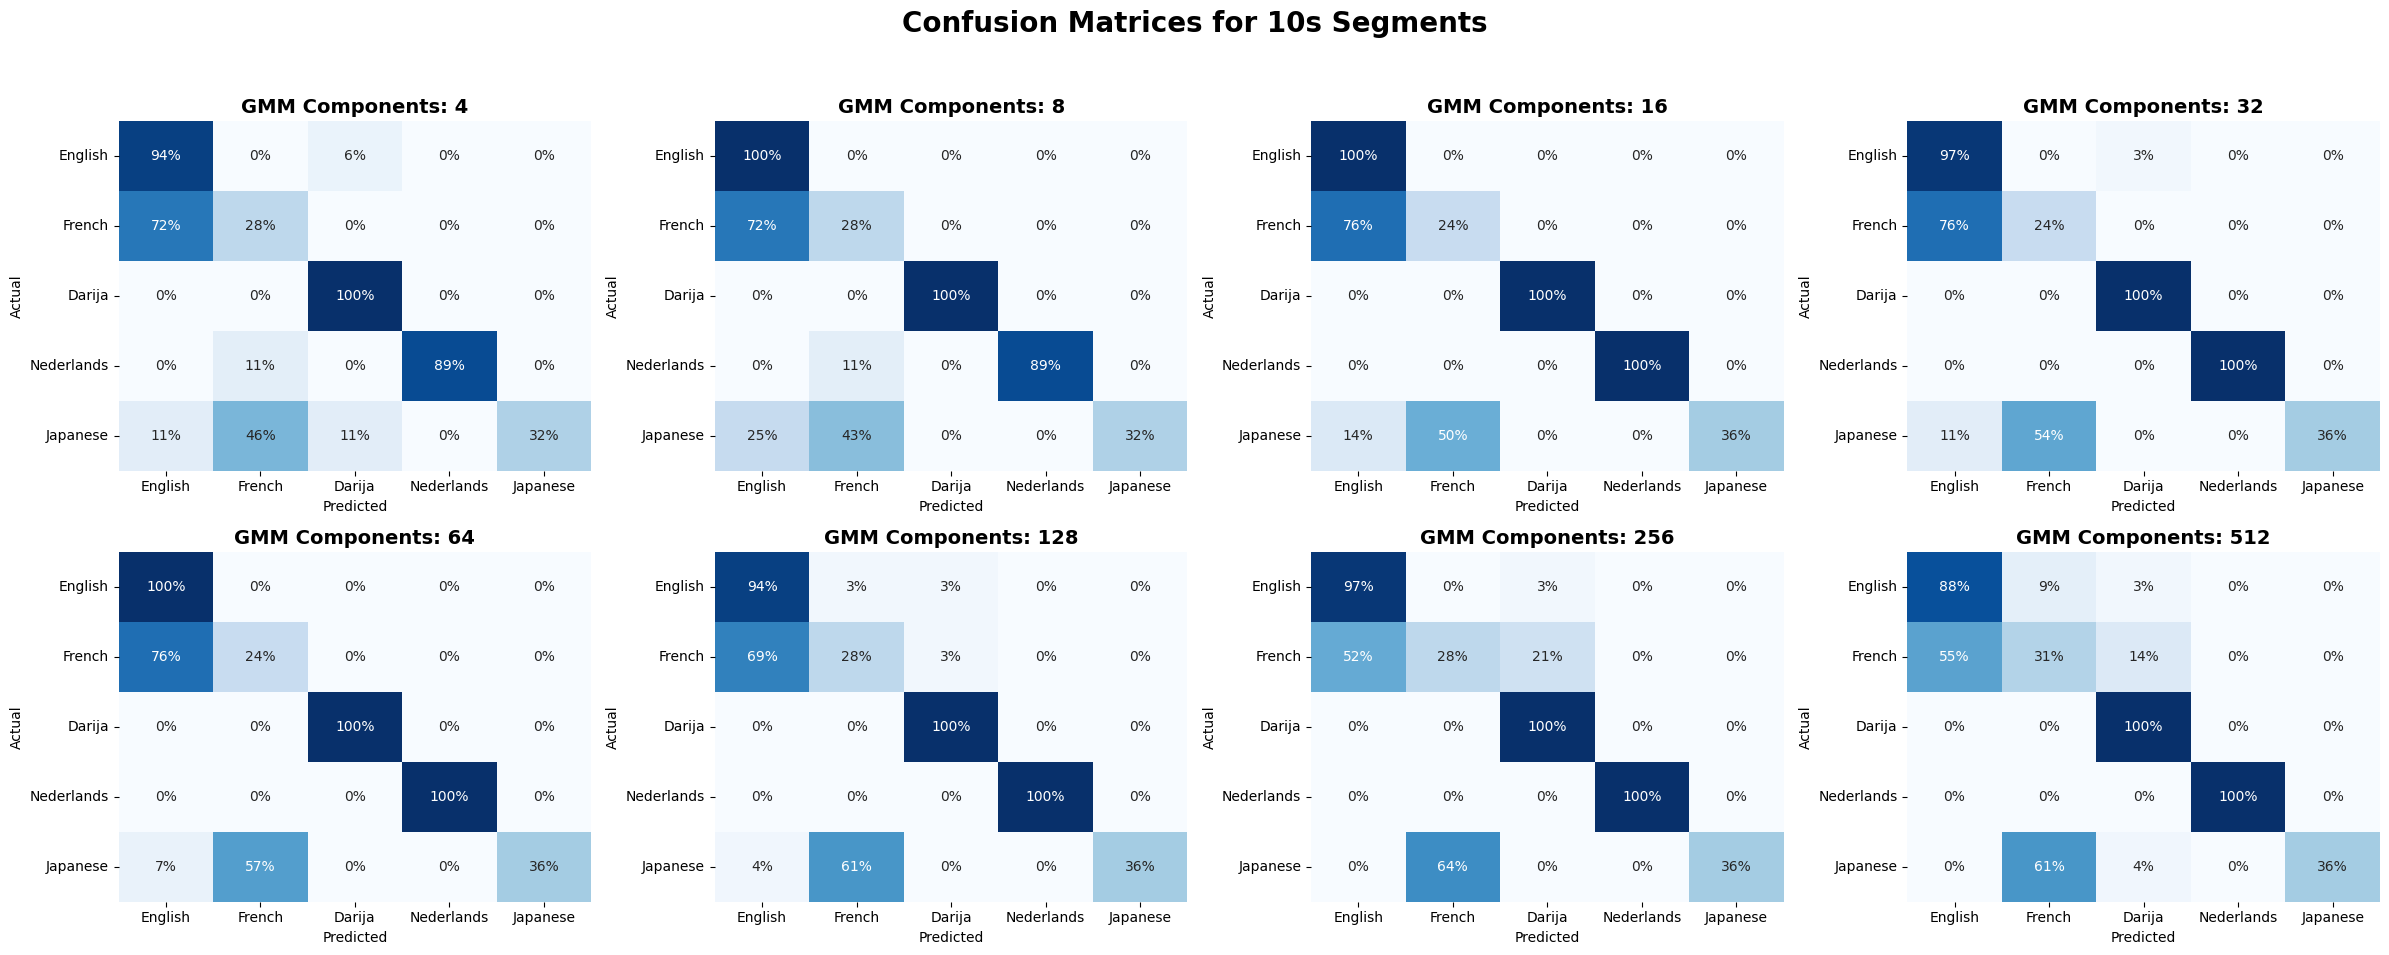


📂 Testing Segment Duration: 15s (1500 frames)


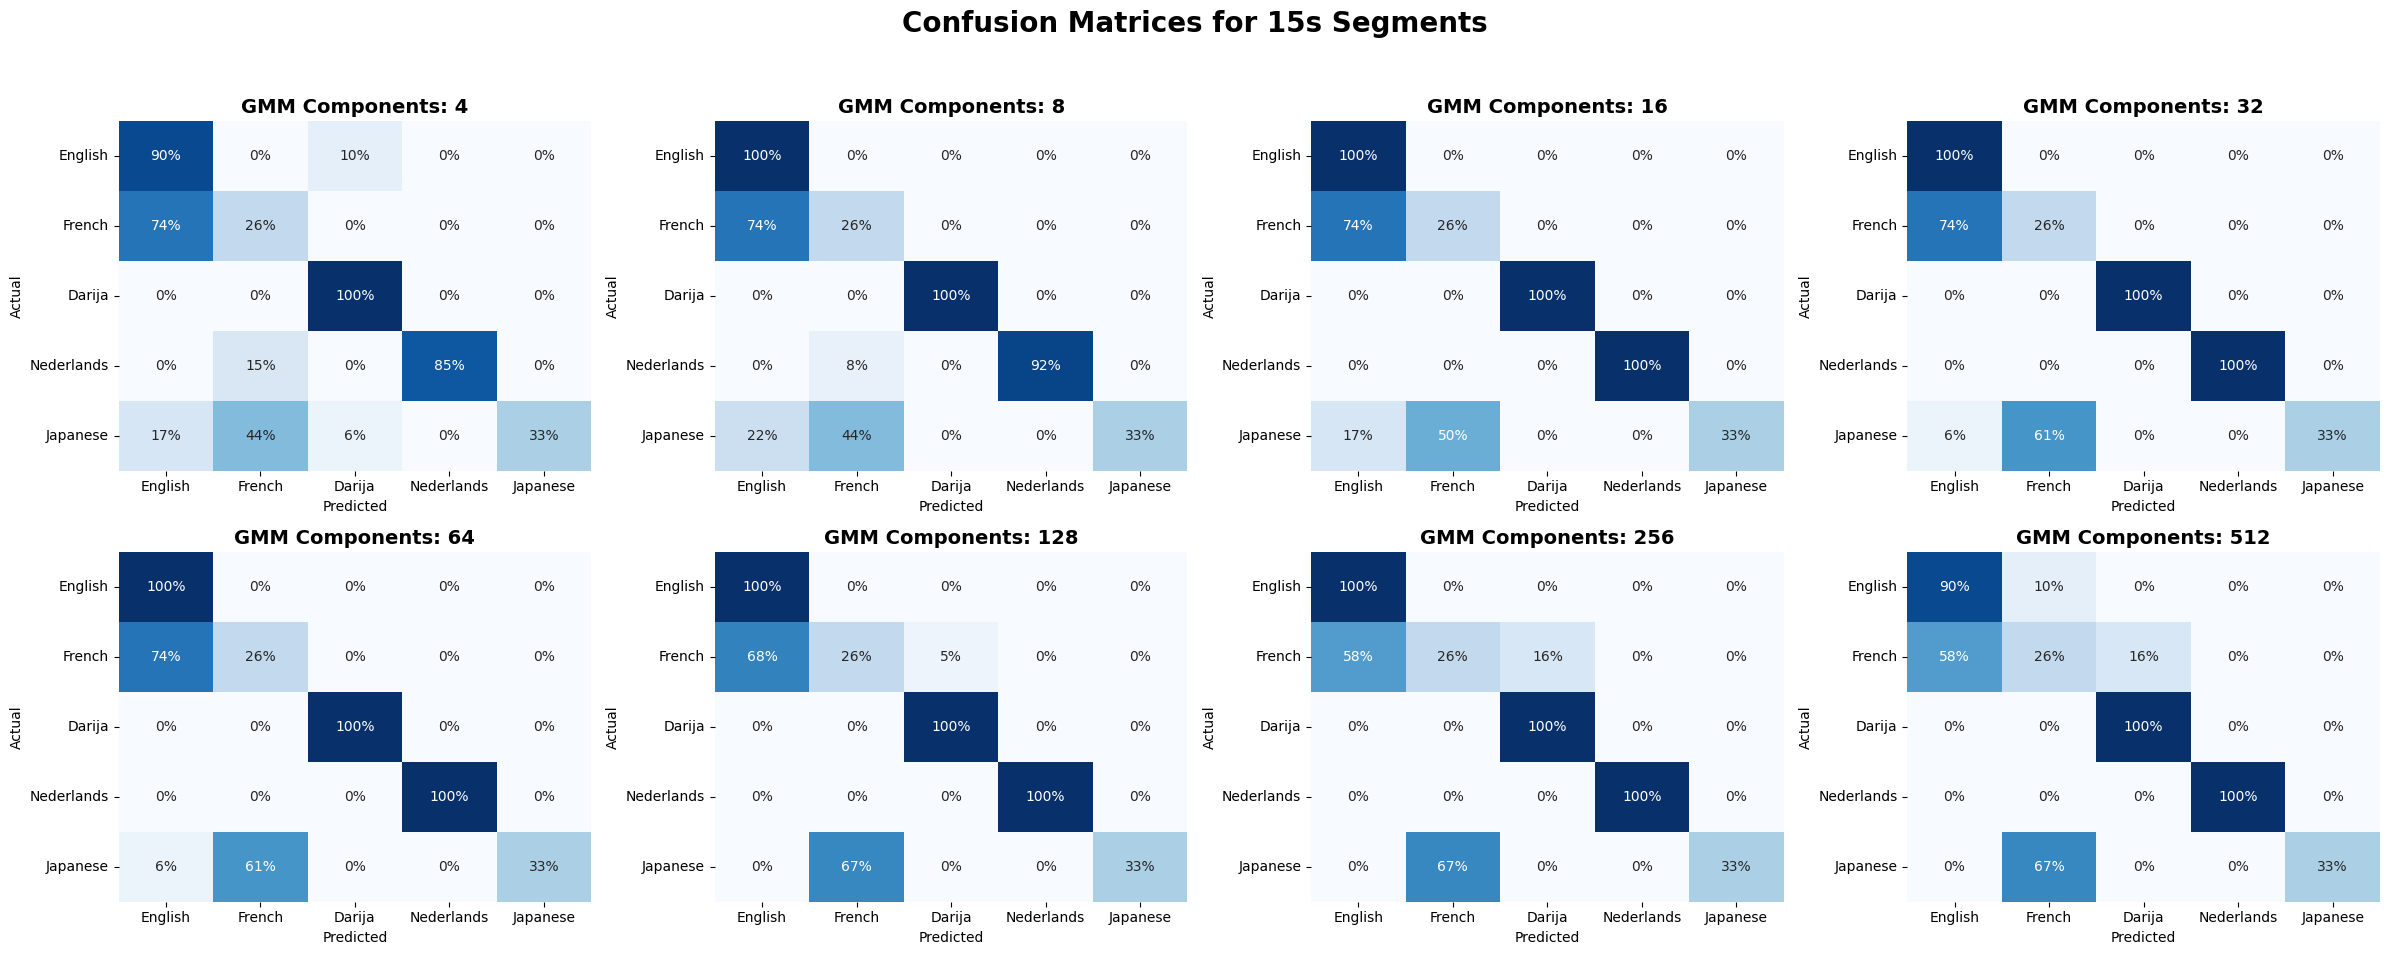

In [18]:
# ==========================================
# 5. EVALUATION LOGIC
# ==========================================
models = load_all_models()

# We want 2 rows and 4 columns
nrows, ncols = 2, 4

# Store results for plotting
det_data = {d: {n: {'y_true': [], 'y_score': []} for n in GMM_COMPONENTS} for d in SEGMENT_DURATIONS}

print("\n--- Running Evaluation (Identification & Verification) ---")

for duration in SEGMENT_DURATIONS:
    frames_needed = int(duration / MFCC_STEP)
    print(f"\n📂 Testing Segment Duration: {duration}s ({frames_needed} frames)")

    # Create a figure for this Duration containing 8 subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(24, 10))
    fig.suptitle(f"Confusion Matrices for {duration}s Segments", fontsize=20, weight='bold')

    # Flatten axes array for easy iteration (from 2D to 1D list)
    axes_flat = axes.flatten()

    for idx, n_comp in enumerate(GMM_COMPONENTS):
        y_true_id = []
        y_pred_id = []

        # Iterate through ground truth languages
        # for true_lang in LANGUAGES:
        #     # Combine all features for this language to slice easily
        #     if not test_features[true_lang]: continue

        #     # Loop through each file's features
        #     for file_feat in test_features[true_lang]:
        #         # Slice into segments of 'duration'
        #         num_segments = len(file_feat) // frames_needed

        #         for i in range(num_segments):
        #             segment = file_feat[i*frames_needed : (i+1)*frames_needed]

        #             # 1. IDENTIFICATION: Find which model gives best score
        #             scores = {}
        #             for model_lang in LANGUAGES:
        #                 if n in models[model_lang]:
        #                     model = models[model_lang][n]
        #                     try:
        #                         score = model.score(segment)
        #                         scores[model_lang] = score

        #                         # 2. VERIFICATION DATA
        #                         # Target = 1 (Same Lang), Impostor = 0 (Diff Lang)
        #                         is_target = 1 if model_lang == true_lang else 0
        #                         det_data[duration][n]['y_true'].append(is_target)
        #                         det_data[duration][n]['y_score'].append(score)

        #                     except:
        #                         pass

        #             if scores:
        #                 predicted_lang = max(scores, key=scores.get)
        #                 y_true_id.append(true_lang)
        #                 y_pred_id.append(predicted_lang)
        for true_lang in LANGUAGES:
            if not test_features[true_lang]: continue

            # 1. Stack all audio for this language into one stream to ensure data continuity
            full_lang_stream = np.vstack(test_features[true_lang])

            # 2. Slice into chunks of exactly 'duration' size
            # This ensures every test sample is exactly 5s (or 10s/15s) of pure speech
            num_segments = len(full_lang_stream) // frames_needed

            for i in range(num_segments):
                # Grab the specific chunk of frames
                segment = full_lang_stream[i*frames_needed : (i+1)*frames_needed]

                scores = {}
                for model_lang in LANGUAGES:
                    # Check if model exists
                    if n_comp in models[model_lang]:
                        try:
                            model = models[model_lang][n_comp]
                            score = model.score(segment)
                            scores[model_lang] = score

                            # Data for DET Curve
                            is_target = 1 if model_lang == true_lang else 0
                            det_data[duration][n_comp]['y_true'].append(is_target)
                            det_data[duration][n_comp]['y_score'].append(score)
                        except:
                            scores[model_lang] = -np.inf

                # Find Winner
                if scores:
                    winner = max(scores, key=scores.get)
                    y_true_id.append(true_lang)
                    y_pred_id.append(winner)

        # --- PLOT CONFUSION MATRIX (Only for n=32 and n=512 for brevity) ---
        if len(y_true_id) > 0:
            ax = axes_flat[idx] # Select the specific box in the grid

            cm = confusion_matrix(y_true_id, y_pred_id, labels=LANGUAGES)

            # Draw Heatmap
            sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt='.0%', cmap='Blues',
                        xticklabels=LANGUAGES, yticklabels=LANGUAGES, ax=ax, cbar=False)

            ax.set_title(f"GMM Components: {n_comp}", fontsize=14, weight='bold')
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
        else:
            axes_flat[idx].text(0.5, 0.5, "No Data", ha='center')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for title
    plt.show()